In [8]:
#Importando librerias
import geopandas as gpd
import matplotlib.pyplot as plt
import zipfile
import os
import matplotlib.image as mpimg
import pandas as pd


In [2]:
!pip install rasterio
import rasterio as rio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 84.4 MB/s eta 0:00:00


In [3]:
!pip install shapely
from shapely.geometry import box

In [6]:
# Ruta del archivo zip
zip_paths = ['/content/09_ciudaddemexico.zip', '/content/13_hidalgo.zip', '/content/15_mexico.zip']
# Descomprimir el archivo zip
with zipfile.ZipFile(zip_paths[0], 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data')
with zipfile.ZipFile(zip_paths[1], 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data')
with zipfile.ZipFile(zip_paths[2], 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data')

In [9]:
# Cargar el shapefile en este primer approach usamos el estado
agebsCDMX = gpd.read_file('/content/sample_data/conjunto_de_datos/09a.shp')
agebsHidalgo = gpd.read_file('/content/sample_data/conjunto_de_datos/13a.shp')
agebsEdoMex = gpd.read_file('/content/sample_data/conjunto_de_datos/15a.shp')
# Unir los tres GeoDataFrames
agebs_unidos = gpd.GeoDataFrame(pd.concat([agebsCDMX, agebsHidalgo, agebsEdoMex], ignore_index=True))

# Guardar el shapefile resultante
agebs_unidos.to_file('/content/sample_data/conjunto_de_datos/agebs_unidos.shp')

# Calcular los centroides y agregarlos al GeoDataFrame
agebs_unidos['centroid'] = agebs_unidos['geometry'].centroid

# Crear un nuevo GeoDataFrame solo con los centroides
centroides = gpd.GeoDataFrame(agebs_unidos['centroid'], geometry='centroid')

# Guardar el nuevo GeoDataFrame
centroides.to_file("centroides_agebs.shp")

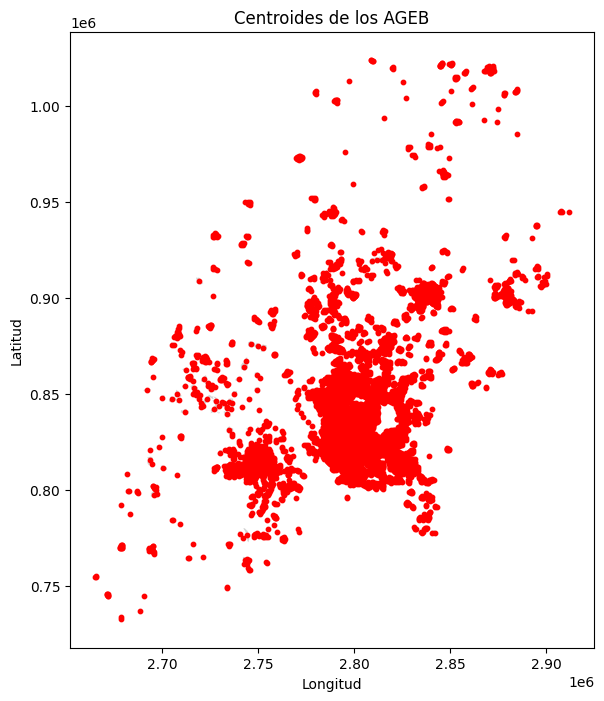

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
agebs_unidos.plot(ax=ax, color='lightgray')
centroides.plot(ax=ax, color='red', markersize=10)


ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
plt.title('Centroides de los AGEB')
plt.show()

CRS de agebs: PROJCS["MEXICO_ITRF_2008_LCC",GEOGCS["ITRF2008",DATUM["International_Terrestrial_Reference_Frame_2008",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","1061"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",12],PARAMETER["central_meridian",-102],PARAMETER["standard_parallel_1",17.5],PARAMETER["standard_parallel_2",29.5],PARAMETER["false_easting",2500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
CRS de raster_extent: PROJCS["WGS 84 / UTM zone 14N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["cent

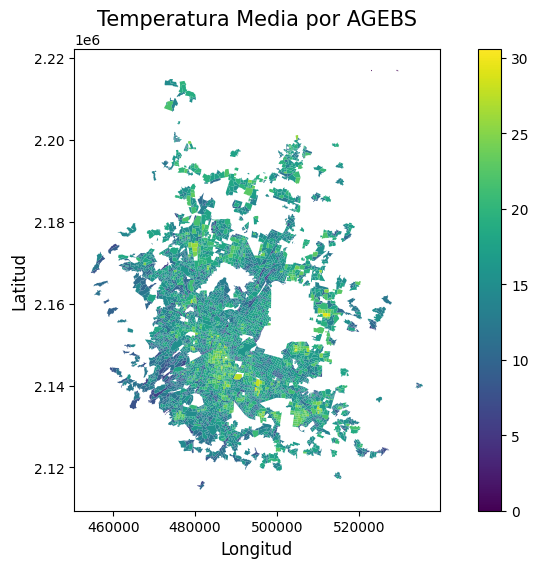

In [17]:
from rasterio.mask import mask
import numpy as np
from shapely.geometry import box


# Abre la imagen raster
img = rio.open('/content/ht_island_cent_Ciudad de México.tif')

# Extrae los datos del raster como un array de NumPy
raster_data = img.read(1)

# Crea un GeoDataFrame desde los límites del raster
raster_bounds = img.bounds
raster_extent = gpd.GeoDataFrame({'geometry': [box(*raster_bounds)]}, geometry='geometry', crs=img.crs)

# Verifica los CRS
print("CRS de agebs:", agebs_unidos.crs)
print("CRS de raster_extent:", raster_extent.crs)

# Reproyecta agebs al CRS de raster_extent
#agebs_unidos = agebs_unidos.to_crs(raster_extent.crs)

# Convirtiendo (MALLAS A AGEBS)
# Reproyectar raster_extent al CRS de agebs
raster_extent = raster_extent.to_crs(agebs_unidos.crs)

# Verifica los CRS
print("CRS de agebs convertido:", agebs_unidos.crs)
print("CRS de raster_extent convertido:", raster_extent.crs)

# Realiza una unión espacial para obtener los polígonos que intersectan
intersecting_polygons = gpd.overlay(agebs_unidos, raster_extent, how='intersection')

# Enmascara el raster usando los polígonos que intersectan
masked_data, masked_transform = mask(img, intersecting_polygons.geometry, crop=True)

# Calcula la temperatura media para cada polígono
mean_temperatures = []
for geom in intersecting_polygons.geometry:
    single_mask, single_transform = mask(img, [geom], crop=True)
    mean_temperatures.append(np.mean(single_mask))

# Añade las temperaturas medias al GeoDataFrame
intersecting_polygons['temperatura'] = mean_temperatures

# Fusiona los resultados de vuelta al GeoDataFrame original
agebs_with_temp = agebs_unidos.merge(intersecting_polygons[['centroid', 'temperatura']], on='centroid', how='left')

# Visualiza
ax = agebs_with_temp.plot(column='temperatura', legend=True, figsize=(10, 6))

# Añadiendo título y etiquetas de los ejes
ax.set_title('Temperatura Media por AGEBS', fontsize=15)
ax.set_xlabel('Longitud', fontsize=12)
ax.set_ylabel('Latitud', fontsize=12)

# Mostrar el gráfico
plt.show()



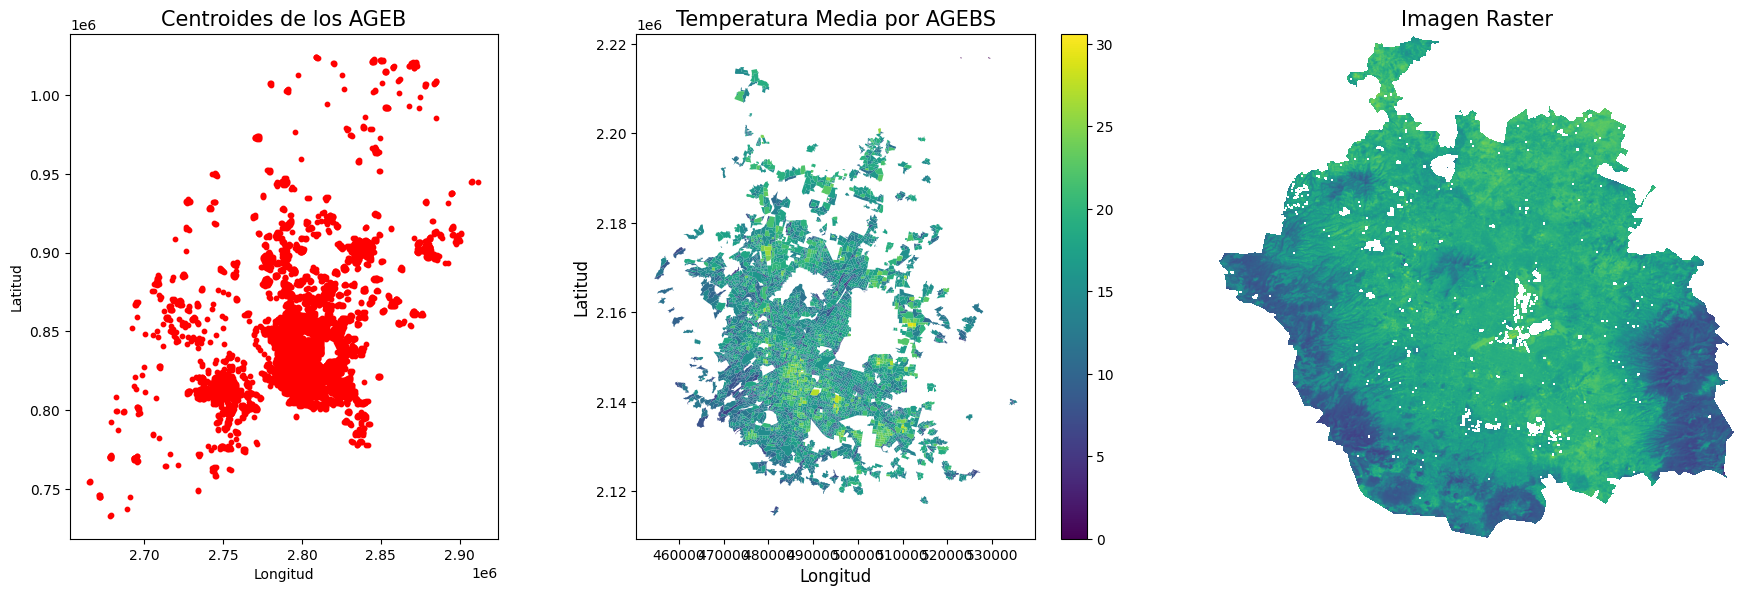

In [18]:
import rasterio
# Crea una figura con tres subgráficas
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Primer gráfico
centroides.plot(ax=axes[0], color='red', markersize=10)
axes[0].set_title('Centroides de los AGEB', fontsize=15)
axes[0].set_xlabel('Longitud')
axes[0].set_ylabel('Latitud')

# Segundo gráfico
agebs_with_temp.plot(column='temperatura', ax=axes[1], legend=True)
axes[1].set_title('Temperatura Media por AGEBS', fontsize=15)
axes[1].set_xlabel('Longitud', fontsize=12)
axes[1].set_ylabel('Latitud', fontsize=12)

# Tercera columna: cargar y mostrar una imagen raster
with rasterio.open('/content/ht_island_cent_Ciudad de México.tif') as src:
    imgRaster = src.read(1)  # Leer la primera banda

# Muestra la imagen raster
axes[2].imshow(imgRaster, aspect='auto')
axes[2].axis('off')  # Opcional: desactiva los ejes
axes[2].set_title('Imagen Raster', fontsize=15)

# Ajusta los límites del eje
axes[2].set_xlim(0, img.shape[1])
axes[2].set_ylim(img.shape[0], 0)

# Ajusta el diseño para evitar solapamientos
plt.subplots_adjust(wspace=0.3)
plt.tight_layout()

# Muestra los gráficos
plt.show()